In [1]:
import pandas as pd
import seaborn as sns
from IPython.display import display as disp
from scipy import stats
import numpy as np
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

In [8]:
# df_old = pd.read_excel('Опрос_нейромифы_для_стат_анализа_2.xlsx', header=[1])
df = pd.read_excel('data/data_raw/Опрос_нейромифы_для_стат_анализа_2.xlsx', header=[1])
df.columns = ['#', 'F_T', 'F_F', 'F_N', 'M_T', 'M_F', 'M_N', 'Age', 'Ed', 'Teacher', 'None', 'BioChem', 'Psy', 'IT']
df = df[['#', 'F_T', 'F_F', 'F_N', 'M_T', 'M_F', 'M_N', 'Age', 'Ed', 'Teacher', 'BioChem', 'Psy', 'IT', 'None']]

label = df['Teacher'].combine_first(df['IT']).combine_first(df['BioChem']).combine_first(df['Psy']).combine_first(df['None'])

df = df[['#', 'F_T', 'F_F', 'F_N', 'M_T', 'M_F', 'M_N', 'Age', 'Ed']]
df['Label'] = label
df['Correct'] = (df['F_T'] + df['M_F'])/45
df['Unsure'] = (df['F_N'] + df['M_N'])/45
df[['M_T', 'M_F', 'M_N']] /= 25
df[['F_T', 'F_F', 'F_N']] /= 20

df = df[['#', 'F_T', 'F_N', 'M_F', 'M_N', 'Correct', 'Unsure', 'Age', 'Ed', 'Label']]
df = df.rename(columns={
    'F_T': 'Facts_correct',
    'F_N': 'Facts_unsure',
    'M_F': 'Myths_correct',
    'M_N': 'Myths_unsure',
})

df['Specialization'] = (df['Label'] == 'Педагог')*1 + (df['Label'] == 'Психолог')*2
df.Specialization = df.Specialization.map({0: 'Не педагог', 1:'Педагог', 2:'Психолог'})
df = df.dropna()
df['#'] = df['#'].astype(int)
df = df.rename(columns={'#':'Subject'})
df['Age'] = df['Age'].astype(int)

print(len(df))

df_gender = pd.read_excel('data/data_raw/neuromyths_with_gender.xlsx', header=1)[['№ опрошенного', 'Пол']]
df_gender = df_gender.rename(columns={'№ опрошенного': 'Subject', 'Пол': "Gender"})
df_gender.Subject = df_gender.Subject.astype(int)

journals_marker = 'Использует научные журналы как источник знаний о нейронауках?'
interest_marker = 'Интересуетесь ли вы нейронауками?'
df_interest = pd.read_excel('data/data_raw/neuromyths_with_interest.xlsx', header=1)[['№ опрошенного', journals_marker, interest_marker]]
rename_dict = {
    '№ опрошенного': 'Subject',
    journals_marker: 'Reliable source',
    interest_marker: 'Interest'
}
df_interest = df_interest.rename(columns=rename_dict)
df_interest.Interest = df_interest.Interest.replace({'Не интересуюсь': 0, 'В некоторой степени интересуюсь': 1, 'Крайне заинтересован': 2})
df_interest['Reliable source'] = df_interest['Reliable source'].replace({'Да': 'Yes', 'Нет': 'No'})
df_interest.Subject = df_gender.Subject.astype(int)

df = df.merge(df_gender, on='Subject')
df = df.merge(df_interest, on='Subject')

df = df.query('Age < 35')


1068


In [7]:
sas = ['Myths_correct', 'Myths_unsure', 'Facts_correct', 'Facts_unsure']
new_df = df.melt([
        'Subject',
        'Ed',
        'Label',
        'Gender',
        'Age',
        'Reliable source',
        'Interest'
    ], value_vars=sas)

new_df['Question'] = new_df.variable.map(lambda x: x.split('_')[0])

mapper_dict = {'correct': 'Correct', 'unsure':'Unsure'}
new_df.variable = new_df.variable.map(lambda x: mapper_dict[x.split('_')[-1]])
new_df = new_df.rename(columns={
    'variable':'Answer',
    'Label': 'Specialization',
    'Ed': 'Education',
})
new_df.replace({
    'Education': {
        'младший': 'Intermediate',
        'старший': 'Senior',
    },
    'Specialization': {
        "БиоХим": "C&B",
        "ФизМатИТ": "P&M&IT",
        "Педагог": "Pedagogy",
        "Психолог": "Psychology",
    },
    'Gender': {
        'Мужской': 'Male',
        'Женский': 'Female'
    }
}, inplace=True)

new_df.to_csv('data/data_processed/myths-removed35-added-gen-int-src.csv', index=False)
new_df.head()

,Subject,Education,Specialization,Gender,Age,Reliable source,Interest,Answer,value,Question
0,1,Intermediate,Pedagogy,Female,17,No,0,Correct,0.52,Myths
1,2,Intermediate,Psychology,Female,17,No,1,Correct,0.40,Myths
2,3,Intermediate,Psychology,Female,17,No,0,Correct,0.40,Myths
3,4,Intermediate,Psychology,Male,17,No,1,Correct,0.44,Myths
4,5,Intermediate,Pedagogy,Female,17,No,0,Correct,0.36,Myths


In [12]:
sas = df.query('Ed == "младший" and Label == "Педагог"').Correct.to_numpy()
space = np.linspace(0, 1, 1000)
space = np.repeat(space, len(sas)).reshape(1000, len(sas))
cdf = (sas < space).sum(-1)/len(sas)
space = space[:, 0]
# plt.hist(sas)
mu, sigma = np.mean(sas), np.std(sas)
stats.kstest(sas, stats.norm(mu, sigma).cdf)

KstestResult(statistic=0.0753982271724204, pvalue=0.21894827004579775)

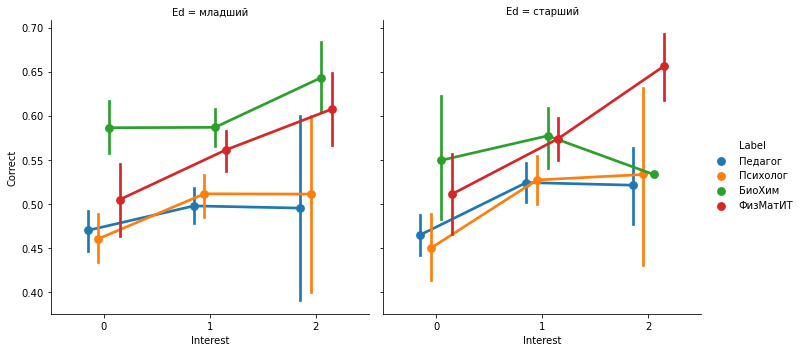

In [41]:
sns.catplot(x='Interest', y='Correct', hue='Label', col='Ed', data=df, kind='point', dodge=0.3);

In [43]:
def fun(obj):
    return pd.DataFrame([stats.pearsonr(obj.Interest, obj.Correct)], columns=['r', 'pval'])
stats_res = df.groupby(['Label', 'Ed']).apply(fun)
stats_res['p.adj.holm'] = multipletests(stats_res.pval, method='holm')[1]
stats_res['p.sign'] = stats_res['p.adj.holm'] < 0.05
stats_res

r      pval  p.adj.holm  p.sign
Label    Ed                                               
БиоХим   младший 0  0.158946  0.080347    0.241040   False
         старший 0  0.077868  0.594857    0.594857   False
Педагог  младший 0  0.119468  0.100638    0.241040   False
         старший 0  0.239049  0.000867    0.006069    True
Психолог младший 0  0.222359  0.011318    0.045273    True
         старший 0  0.312109  0.003073    0.018440    True
ФизМатИТ младший 0  0.308444  0.004554    0.022772    True
         старший 0  0.363228  0.000175    0.001402    True

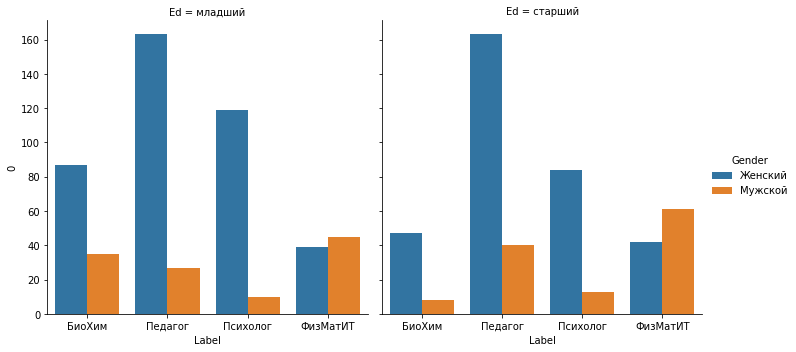

In [32]:
df_counts = df[['Gender', 'Label', 'Ed']].value_counts().sort_index().reset_index()

sns.catplot(x='Label', hue='Gender', y=0, col='Ed', data=df_counts, kind='bar')

In [39]:
df[['Subject', 'Correct', 'Unsure', 'Ed', 'Specialization']].to_csv('myths_typ2.csv', index=False)

In [18]:
temp_df = df[['#', 'Ed', 'Specialization', 'Answered_correctly', 'Not_answered']]
temp_df = temp_df.rename(columns={'#':'Subject'})
temp_df.to_csv('myths_typ2.csv', index=False)

In [55]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for i in ['M_T', 'M_F', 'M_N', 'F_T', 'F_F', 'F_N']:
    disp(i)
    myth_lm = ols(f'{i} ~ C(Ed)*C(Teacher)', data=df).fit()
    table = sm.stats.anova_lm(myth_lm, typ=1)
    disp(table)
    # sns.pointplot(x='Ed', y=i, hue='Label', data=df, capsize=0.025, dodge=0.2)

'M_T'

,df,sum_sq,mean_sq,F,PR(>F)
C(Ed),1.0,0.016399,0.016399,0.853771,0.355697
C(Teacher),2.0,0.394907,0.197453,10.279849,0.000038
C(Ed):C(Teacher),2.0,0.148393,0.074197,3.862835,0.021304
Residual,1062.0,20.398688,0.019208,NaN,NaN


'M_F'

,df,sum_sq,mean_sq,F,PR(>F)
C(Ed),1.0,0.003014,0.003014,0.174818,6.759494e-01
C(Teacher),2.0,1.300345,0.650172,37.716439,1.498065e-16
C(Ed):C(Teacher),2.0,0.025614,0.012807,0.742923,4.759686e-01
Residual,1062.0,18.307215,0.017238,NaN,NaN


'M_N'

,df,sum_sq,mean_sq,F,PR(>F)
C(Ed),1.0,0.005353,0.005353,0.218557,0.640238
C(Teacher),2.0,0.271679,0.135840,5.546405,0.004015
C(Ed):C(Teacher),2.0,0.057421,0.028710,1.172255,0.310068
Residual,1062.0,26.009955,0.024491,NaN,NaN


'F_T'

,df,sum_sq,mean_sq,F,PR(>F)
C(Ed),1.0,0.102213,0.102213,4.324892,3.779824e-02
C(Teacher),2.0,0.982634,0.491317,20.788918,1.392328e-09
C(Ed):C(Teacher),2.0,0.124562,0.062281,2.635273,7.216820e-02
Residual,1062.0,25.098876,0.023634,NaN,NaN


'F_F'

,df,sum_sq,mean_sq,F,PR(>F)
C(Ed),1.0,0.009407,0.009407,0.891325,0.345333
C(Teacher),2.0,0.028876,0.014438,1.367973,0.255071
C(Ed):C(Teacher),2.0,0.002210,0.001105,0.104705,0.900600
Residual,1062.0,11.208664,0.010554,NaN,NaN


'F_N'

,df,sum_sq,mean_sq,F,PR(>F)
C(Ed),1.0,0.049602,0.049602,2.234434,1.352631e-01
C(Teacher),2.0,0.682295,0.341147,15.367634,2.634357e-07
C(Ed):C(Teacher),2.0,0.127302,0.063651,2.867289,5.729306e-02
Residual,1062.0,23.575433,0.022199,NaN,NaN


<AxesSubplot:xlabel='Ed', ylabel='F_T'>

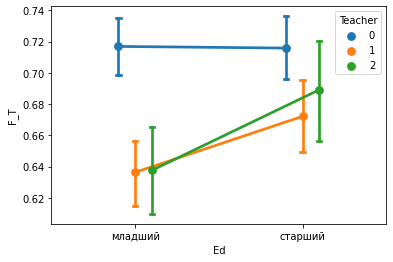

In [57]:
sns.pointplot(x='Ed', y='F_T', hue='Teacher', data=df, capsize=0.025, dodge=0.2)

<AxesSubplot:xlabel='Ed', ylabel='M_T'>

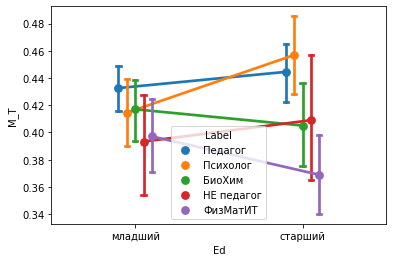

In [65]:
sns.pointplot(x='Ed', y='M_T', hue='Label', data=df, capsize=0.025, dodge=0.2)

In [79]:
mapper_dict = {0: 'Не педагог', 1:'Педагог', 2:'Психолог'}

sas = ['M_T', 'M_F', 'M_N', 'F_T', 'F_F', 'F_N']
new_df = df.melt(['#', 'Ed', 'Teacher'], ['M_T', 'M_F', 'M_N', 'F_T', 'F_F', 'F_N'])
new_df.Teacher = new_df.Teacher.map(lambda x: mapper_dict[x])

mapper_dict = {'M': 'Myth', 'F':'Fact'}
new_df['Question'] = new_df.variable.map(lambda x: mapper_dict[x[0]])

mapper_dict = {'T': 'True', 'F':'False', 'N': 'Not sure'}
new_df.variable = new_df.variable.map(lambda x: mapper_dict[x[-1]])
new_df = new_df.rename(columns={'variable':'Answer'})
new_df.rename(columns={'#':'Subject'})

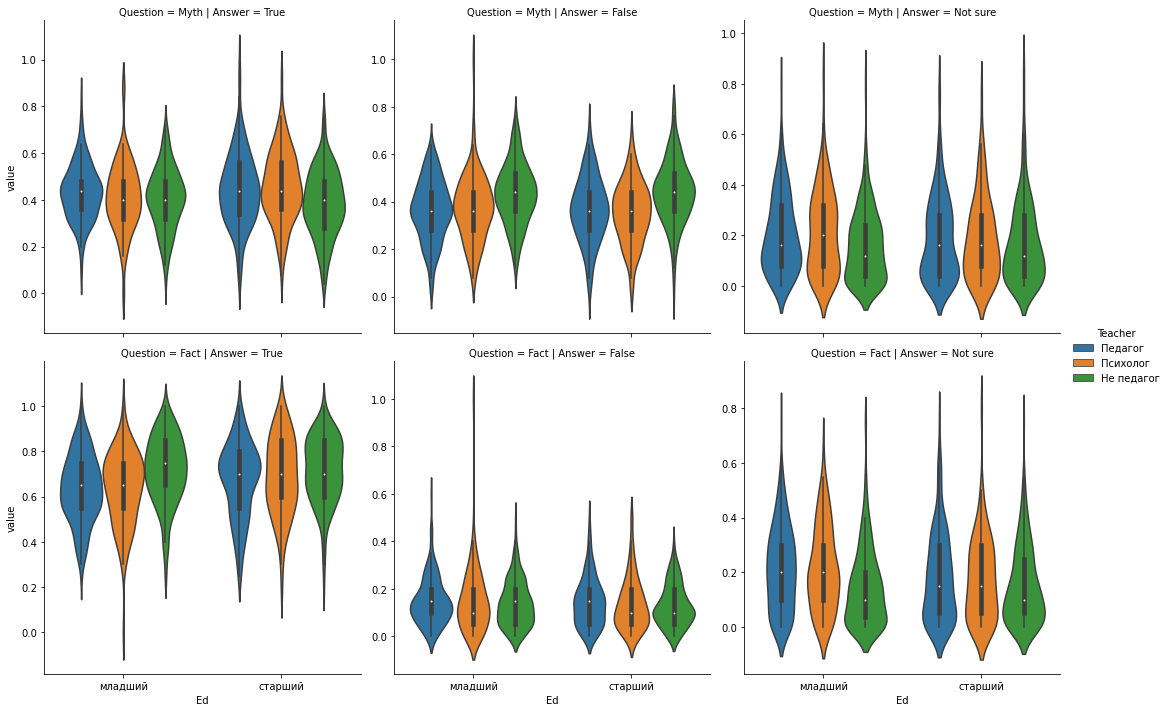

In [96]:
sns.catplot(x='Ed', y='value', hue='Teacher', col='Answer', row='Question', data=new_df, capsize=0.025, dodge=0.2, kind='violin', sharey=False)

In [110]:
func = lambda x: stats.kstest(x, 'norm').pvalue
new_df[['Answer', 'Ed', 'Teacher', 'Question', 'value']].groupby(['Answer', 'Teacher', 'Ed', 'Question']).apply(func)

Answer    Teacher     Ed       Question
False     Не педагог  младший  Fact        1.542879e-124
                               Myth        7.649921e-166
                      старший  Fact         4.755281e-80
                               Myth        1.426946e-125
          Педагог     младший  Fact        2.221321e-102
                               Myth        5.198805e-107
                      старший  Fact         2.373714e-97
                               Myth        2.006649e-124
          Психолог    младший  Fact        3.985783e-103
                               Myth        3.985783e-103
                      старший  Fact         8.589326e-47
                               Myth         2.761584e-57
Not sure  Не педагог  младший  Fact        3.535071e-164
                               Myth        2.357880e-179
                      старший  Fact        1.749482e-119
                               Myth        1.637131e-135
          Педагог     младший  Fact        4.105

/Users/nikitasmirnov/miniconda3/envs/NCT/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.

/Users/nikitasmirnov/miniconda3/envs/NCT/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.



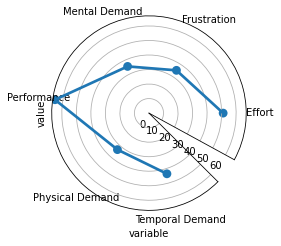

In [11]:
import pandas as pd
import plotly.express as px
import seaborn as sns

df = pd.read_csv('NASA.csv')
df = df.melt(id_vars=['sub'], value_vars=['Mental Demand', 'Physical Demand', 'Temporal Demand', 'Performance', 'Effort', 'Frustration'])

df = df.groupby(['variable'], as_index=False).mean()

fig = px.line_polar(df, r='value', theta='variable', line_close=True)
fig.show()
# sns.pointplot(data=df, x='variable', y='value', ci=None, subplot_kws={'projection': 'polar'})

g = sns.FacetGrid(df, subplot_kws=dict(projection='polar'), size=4,
                  sharex=False, sharey=False, despine=False)

g.map(sns.pointplot, "variable", "value")

In [7]:
df.groupby(['variable'], as_index=False).mean()

,variable,sub,value
0,Effort,7.5,51.071429
1,Frustration,7.5,35.000000
2,Mental Demand,7.5,35.357143
3,Performance,7.5,65.357143
4,Physical Demand,7.5,33.214286
5,Temporal Demand,7.5,43.571429
